In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
plt.style.use("fivethirtyeight")
%matplotlib inline

# Download the data

In [3]:
#!kaggle competitions download -c airbus-ship-detection

In [4]:
# Unzip the dataset
"""

import zipfile
from tqdm import tqdm

with zipfile.ZipFile("./airbus-ship-detection.zip") as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, "./")
        except zipfile.error as e:
            print(e)
"""

'\n\nimport zipfile\nfrom tqdm import tqdm\n\nwith zipfile.ZipFile("./airbus-ship-detection.zip") as zf:\n    for member in tqdm(zf.infolist(), desc=\'Extracting \'):\n        try:\n            zf.extract(member, "./")\n        except zipfile.error as e:\n            print(e)\n'

In [5]:
INPUT_DIR = "./"
TRAIN_FOLDER = INPUT_DIR + "/train_v2"
TEST_FOLDER = INPUT_DIR + "/test_v2"
SEGM_PATH = INPUT_DIR + "/train_ship_segmentations_v2.csv"

In [6]:
NUM_CLASSES = 2
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42

# EDA

In [7]:
df = pd.read_csv(SEGM_PATH)
print(f"Df size is {df.shape[0]}")
df.tail()

Df size is 231723


,ImageId,EncodedPixels
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN
231722,ffffe97f3.jpg,NaN


### From the above we can see that each ship in every image has its own row in the table

In [8]:
from skimage import exposure

def view_random_image(target_dir):
    random_image = random.sample(os.listdir(target_dir), 1)
    img = mpimg.imread(target_dir + "/" + random_image[0])
    
    plt.imshow(img)
    plt.axis("off")
    
    print(f"Image shape: {img.shape}")
    
    return img

### Random image from the dataset

Image shape: (768, 768, 3)


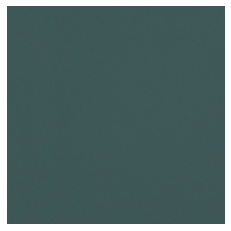

In [9]:
img = view_random_image(TRAIN_FOLDER)

### Let's find out the proportion of empty and non-empty data

N of images in the dataset: 192556
N of non-empty images: 81723
N of empty images: 110833


Text(0.5, 1.0, 'Empty images')

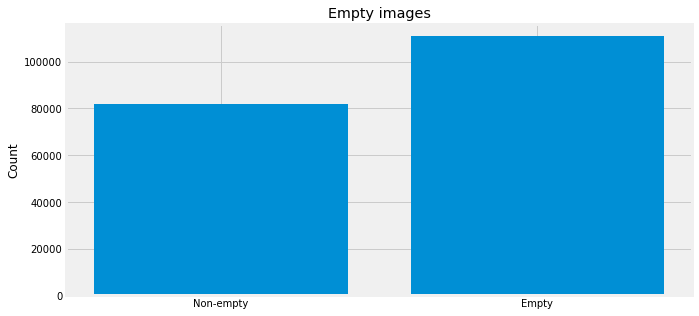

In [10]:
n_images = df['ImageId'].unique().shape[0]
print(f"N of images in the dataset: {n_images}")

n_ship_images = df['EncodedPixels'].notna().sum()
n_empty_images = n_images - n_ship_images
print(f"N of non-empty images: {n_ship_images}")
print(f"N of empty images: {n_empty_images}")

plt.figure(figsize=(10, 5))
plt.bar(['Non-empty', 'Empty'], [n_ship_images, n_empty_images])
plt.ylabel('Count')
plt.title("Empty images")

### As the graph shows, the dataset is skewed towards the empty images (without any ships)

## Counting ships

### Let's count how many ships there can be in 1 image

In [11]:
mask_counts = df['ImageId'].value_counts()
mask_counts

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

### We see that it's anywhere between 1 and 15 ships per image. Let's copy the original dataframe and add a new 'Ships count column'

In [12]:
ship_df = df.copy()
ship_df['ShipCount'] = ship_df['EncodedPixels'].notna().astype(int)

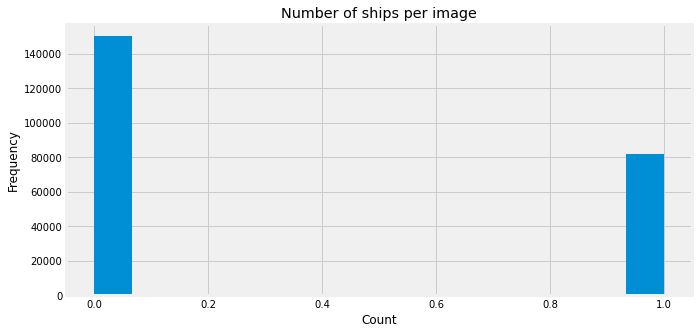

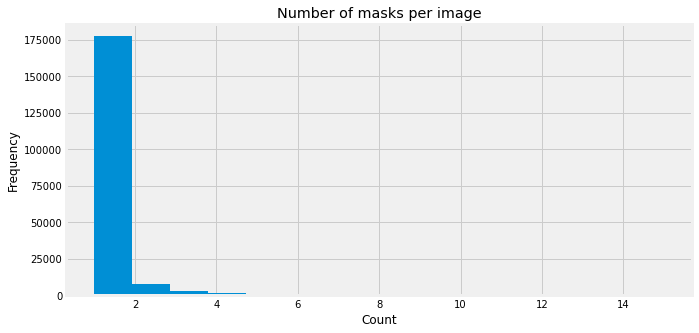

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(ship_df['ShipCount'], bins=15)  # Create a histogram with 30 bins
plt.title("Number of ships per image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(mask_counts, bins=15)  # Create a histogram with 30 bins
plt.title("Number of masks per image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

## Data Manipulations

### NaNs in the dataset correspond to empty masks (i.e. where there is no ships). Let's rle-encode an empty mask to find a substitute for NaN

In [14]:
import rle

rle_with_zeros = rle.rle_encode(np.zeros((768, 768, 1)))
print(rle_with_zeros == '')

True


### As shown above, an rle-encoding of an empty image corresponds to an empry string. Now we shall replace all NaN values with ''

In [15]:
ship_df['EncodedPixels'] = ship_df['EncodedPixels'].fillna('')
df['EncodedPixels'] = df['EncodedPixels'].fillna('')

ship_df.set_index('ImageId', inplace=True)
print(f"Size: {ship_df.shape[0]}")
ship_df.head()

Size: 231723


,EncodedPixels,ShipCount
ImageId,,
00003e153.jpg,,0
0001124c7.jpg,,0
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


### It will be more useful to merge records for same images and their masks. That's what we'll do

In [16]:
ship_df_counts = ship_df[['ShipCount']].groupby('ImageId').sum()
ship_df_masks = ship_df[['EncodedPixels']].groupby('ImageId').agg(' '.join) # Add spaces between mask strings
ship_df = ship_df_counts.join(ship_df_masks)


print(f"Size: {ship_df.shape[0]}")
ship_df.head()

Size: 192556


,ShipCount,EncodedPixels
ImageId,,
00003e153.jpg,0,
0001124c7.jpg,0,
000155de5.jpg,1,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,5,360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg,0,


### Let's find out how balanced is the dataset

In [17]:
(ship_df['ShipCount'].value_counts() / ship_df.shape[0])

0     0.778994
1     0.140759
2     0.039853
3     0.015341
4     0.008424
5     0.004804
6     0.003412
7     0.002108
8     0.001651
9     0.001262
10    0.000872
11    0.000748
12    0.000644
14    0.000395
13    0.000389
15    0.000343
Name: ShipCount, dtype: float64

### 77% of images have no ships, other 15% have 3 or less ships in an image.

### To balance out the negative category, we need to have approximately the same number of images with and without ships.

#### We could subsample empty images in the existing DataFrame.
#### But since we know that our model will take 256x256 images, and the source data is 768x768, we could also choose to generate empty and non-empty images on the go

#### I ended up choosing the second option. I suggest that we remove the negative category from our dataset for now.

array([[<AxesSubplot:title={'center':'ShipCount'}>]], dtype=object)

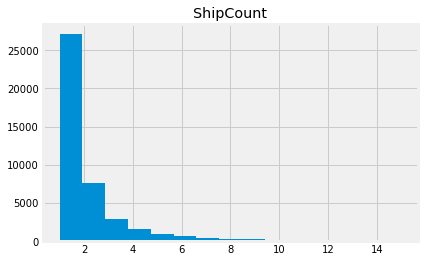

In [18]:
positive = ship_df[ship_df['ShipCount'] != 0]
positive.hist(bins=15)

### Now the distribution looks much more balanced than before

In [19]:
ship_df = positive
ship_df.sample(10)

,ShipCount,EncodedPixels
ImageId,,
87321016f.jpg,3,509230 4 509998 7 510765 8 511533 7 512301 7 5...
1117dbd46.jpg,1,394661 1 395428 3 396195 5 396962 7 397728 8 3...
dcc61f613.jpg,1,489660 4 490428 12 491196 20 491964 28 492731 ...
dc2566b74.jpg,1,453309 4 454069 12 454829 20 455589 28 456353 ...
0877f68a5.jpg,2,363032 1 363800 3 364567 6 365335 7 366102 8 3...
a2c1272a6.jpg,1,330030 6 330788 16 331546 26 332304 36 333067 ...
47a9515bb.jpg,1,262087 6 262849 12 263617 12 264385 12 265153 ...
6e41460ba.jpg,1,118780 2 119548 6 120315 10 121083 13 121851 1...
abdb1dc0d.jpg,1,81166 1 81933 3 82701 5 83468 7 84235 9 85003 ...


### Now let's proceed to splitting the dataset

#### To get training and validation data we used stratified train/test split to preserve the 'ShipCount' distribution

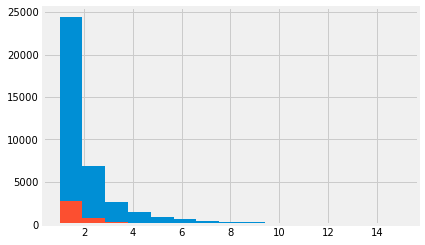

In [29]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(ship_df, test_size=0.1, stratify=ship_df['ShipCount'])

train_df.to_csv('training_set.csv')  
valid_df.to_csv('validation_set.csv')  

plt.hist(train_df['ShipCount'], bins=15)
plt.hist(valid_df['ShipCount'], bins=15)
plt.show()

### Data Augmentation

In [21]:
IMG_SIZE = 768
CROP_SIZE = 256
IMG_C = 3

### balanced_crop_gen is a function that tries to split random input images into equal proportions of empty and non-empty samples.

Before Augmentation


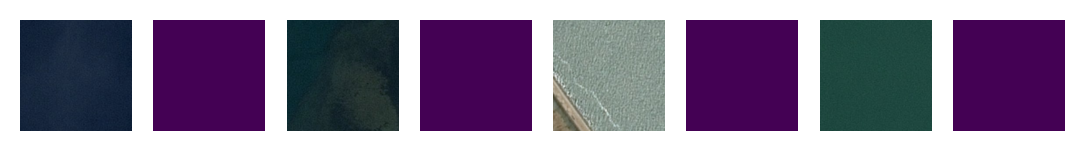

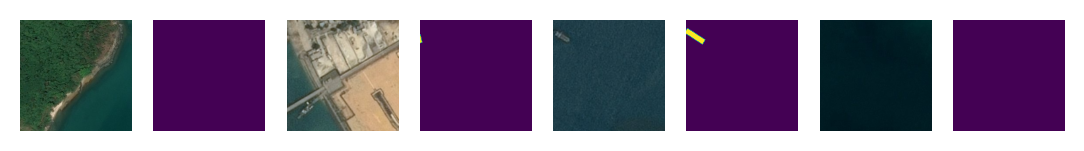

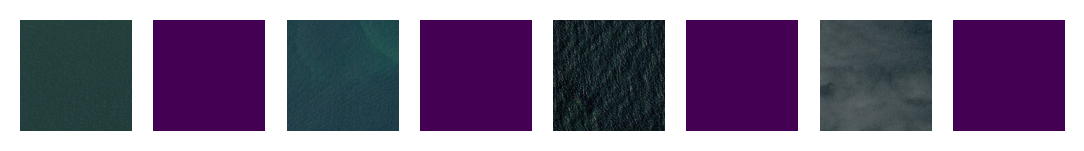

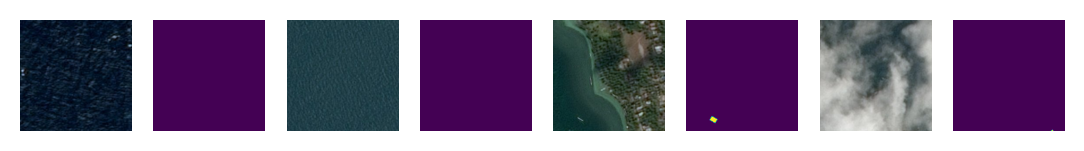

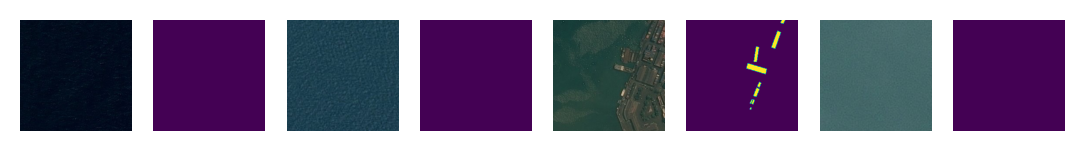

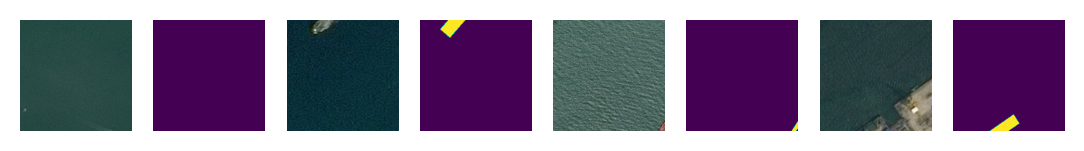

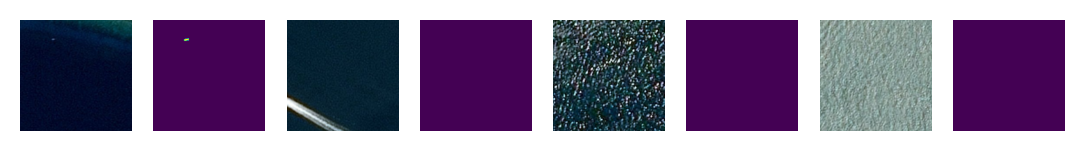

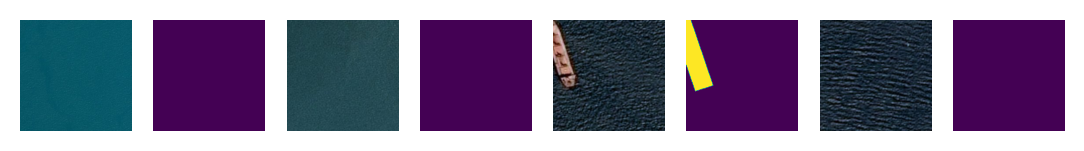

In [22]:
import img_utils

train_x, train_y = next((img_utils.balanced_crop_gen(train_df, TRAIN_FOLDER, BATCH_SIZE, RANDOM_STATE, IMG_SIZE, CROP_SIZE, debug=True)))

### create_aug_gen is a function that flips, shears, zooms the data randomly. This will add more variance to the data

After Augmentation


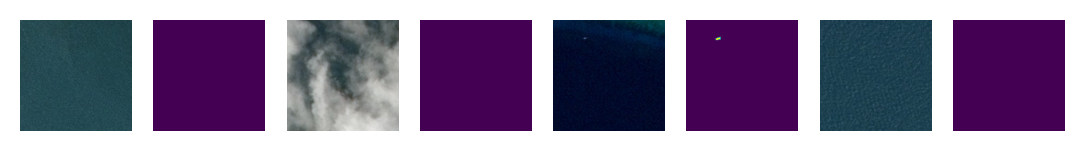

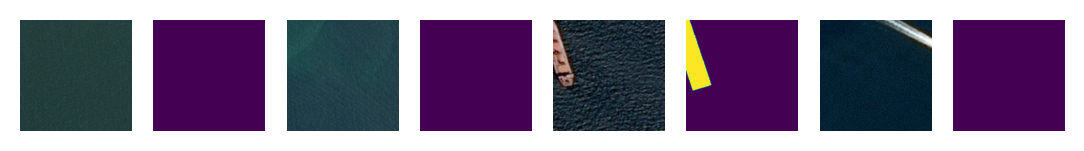

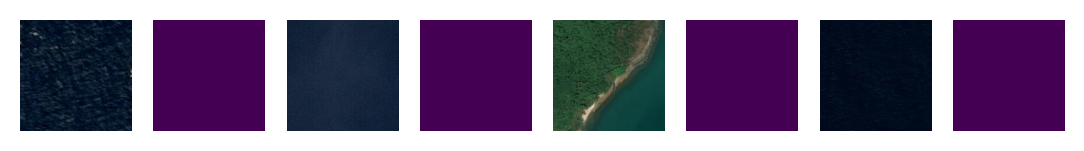

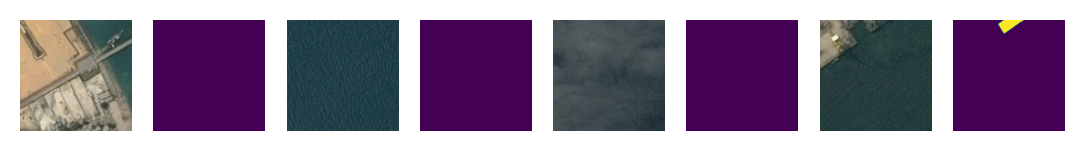

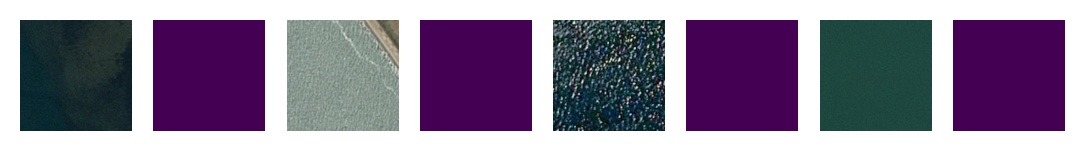

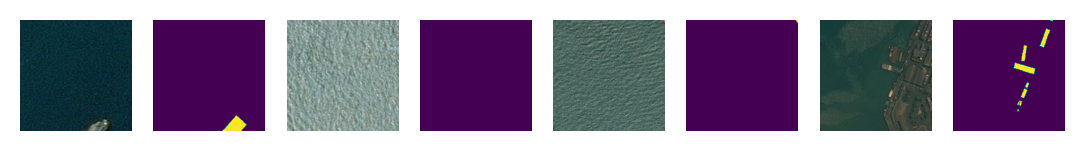

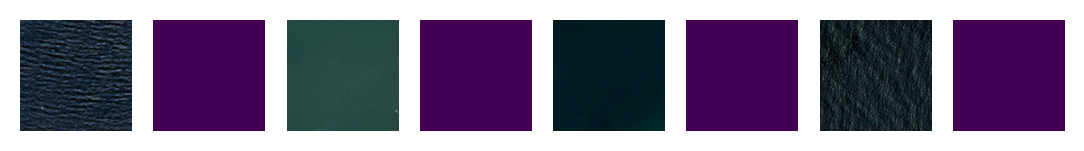

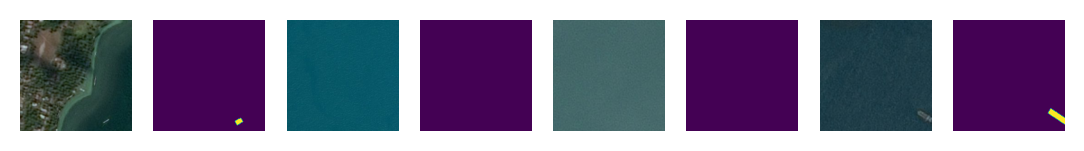

In [23]:
from img_utils import create_aug_gen

train_crop_gen = img_utils.balanced_crop_gen(train_df, TRAIN_FOLDER, BATCH_SIZE, RANDOM_STATE, IMG_SIZE, CROP_SIZE)
train_x, train_y = next(img_utils.create_aug_gen(train_crop_gen, RANDOM_STATE, debug=True))
train_step_count = train_df.shape[0] // BATCH_SIZE

valid_crop_gen = img_utils.balanced_crop_gen(valid_df, TRAIN_FOLDER, BATCH_SIZE, RANDOM_STATE, IMG_SIZE, CROP_SIZE)
valid_x, valid_y = next(img_utils.create_aug_gen(valid_crop_gen, RANDOM_STATE))
valid_step_count = valid_df.shape[0] // BATCH_SIZE

In [24]:
print(f"Train X shape, min, max {train_x.shape, train_x.min(), train_x.max()}")
print(f"Train y shape, min, max {train_y.shape, train_y.min(), train_y.max()}")

print(f"Valid X shape, min, max {valid_x.shape, valid_x.min(), valid_x.max()}")
print(f"Train X shape, min, max {valid_y.shape, valid_y.min(), valid_y.max()}")

Train X shape, min, max ((32, 256, 256, 3), 0.0, 255.0)
Train y shape, min, max ((32, 256, 256, 1), 0.0, 1.0)
Valid X shape, min, max ((32, 256, 256, 3), 0.0, 255.0)
Train X shape, min, max ((32, 256, 256, 1), 0.0, 1.0)


# Preparing train dataset

In [25]:
def get_aug_gen(df):
    crop_gen = img_utils.balanced_crop_gen(train_df, TRAIN_FOLDER, BATCH_SIZE, RANDOM_STATE, IMG_SIZE, CROP_SIZE)
    return img_utils.create_aug_gen(crop_gen, RANDOM_STATE)

## We create training and validation generators that will yield random batches of roughy-balanced images

In [26]:
train_aug_gen = get_aug_gen(train_df)
valid_aug_gen = get_aug_gen(valid_df)

In [27]:
TRAIN_STEP_COUNT = train_df.shape[0] // BATCH_SIZE
VALID_STEP_COUNT = valid_df.shape[0] // BATCH_SIZE

## Finding learning rate

### We will plot lr agains loss, while exponentially increasing loss. The area of sharpest fall will give us an idea of what an optimal lr is

1196/1196 [==============================] - 882s 735ms/step - loss: 0.9931 - mean_io_u: 0.4827 - val_loss: 0.9998 - val_mean_io_u: 0.4967


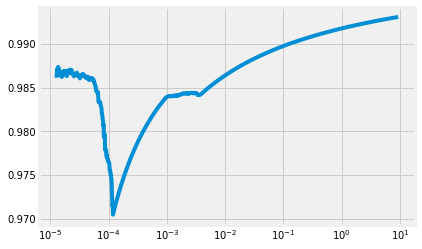

<Figure size 432x288 with 0 Axes>

In [28]:
import lrfind

LR_FIND_EPOCHS = 1

lrfind.lr_find(train_aug_gen, valid_aug_gen, CROP_SIZE, IMG_C, TRAIN_STEP_COUNT, VALID_STEP_COUNT,
               save_path="lrfind-model-{epoch:02d}-{val_loss:.2f}.hdf5", epochs=LR_FIND_EPOCHS)

### Learning rate falls quickest in the vicinity of 8e-5. We will assume it's the optimal learning rate for training

In [30]:
train_aug_gen = get_aug_gen(train_df)
valid_aug_gen = get_aug_gen(valid_df)

In [ ]:
import model

# Model
TRAIN_LEARNING_RATE = 8e-5

SAVE_PATH = "airbus_ships_final-{epoch:02d}-{val_loss:.2f}.hdf5"

TRAIN_EPOCHS = 30

model.train_unet(train_aug_gen, TRAIN_STEP_COUNT, valid_aug_gen, VALID_STEP_COUNT, 
                 crop_size=CROP_SIZE, img_c=IMG_C,
                 lr=TRAIN_LEARNING_RATE, epochs=TRAIN_EPOCHS, save_path=SAVE_PATH)

Epoch 1/30
1196/1196 [==============================] - ETA: 0s - loss: 0.6465 - mean_io_u_5: 0.6093
Epoch 1: val_loss improved from inf to 0.51816, saving model to airbus_ships_final-01-0.52.hdf5
1196/1196 [==============================] - 875s 731ms/step - loss: 0.6465 - mean_io_u_5: 0.6093 - val_loss: 0.5182 - val_mean_io_u_5: 0.5990
Epoch 2/30
1196/1196 [==============================] - ETA: 0s - loss: 0.5168 - mean_io_u_5: 0.6402
Epoch 2: val_loss did not improve from 0.51816
1196/1196 [==============================] - 874s 731ms/step - loss: 0.5168 - mean_io_u_5: 0.6402 - val_loss: 0.5665 - val_mean_io_u_5: 0.5857
Epoch 3/30
1196/1196 [==============================] - ETA: 0s - loss: 0.4640 - mean_io_u_5: 0.6607
Epoch 3: val_loss improved from 0.51816 to 0.50878, saving model to airbus_ships_final-03-0.51.hdf5
1196/1196 [==============================] - 868s 726ms/step - loss: 0.4640 - mean_io_u_5: 0.6607 - val_loss: 0.5088 - val_mean_io_u_5: 0.6589
Epoch 4/30
1196/1196 [===